# Dev: Work in progress

### Isolating and labeling the most severe fraud
 explain upfront how I am looking to isolate a single severe form of fraud 
 since I do not have dollar values to work with. These will include ratings boosters and ATO
     examine what traits the booster vs. ATO share in common or don't share (graph theory traits)
     
MO-steps for each type of fraud scenario
    - ratings boost
        step 1, open fake accounts
        sept 2, rate 


### Approaches for Fraud Detection
which technique works better:
   - account history profile (includes successive negative ratings - make it just prior one to start with)
   - velocity
   - graph theory
    
do any of my graph theory ones come up as a false positive hit? - manually look for these once you think you 
have the criteria down for categorizing the data.

### Background / Purpose
The purpose of this project is to compare strategies for detecting ratings manipulation that occurs when a fraudster sets up fake accounts and then uses them to boost their peer to peer ratings score.

### The Data
I will use five years of peer to peer ratings from the Over The Counter (OTC) Bitcoin Marketplace between 2011 and 2016. In this online marketplace, where users traded products and services for bitcoin, each party has the option of rating the trustworthiness of the person they transacted with. Trust ratings range from -10  representing completely untrustworthy to +10 reflecting a very trusted individual. For the purpose of this analysis, I have categorized these ratings as fraud (-10), untrustworhy (-9 to -1), and trusted (>0). The dataset contains four fields: date, rater, ratee, rating.

OTC Bitcoin Marketplace: <link>
Data Source: <link>

### Marketplace Fraud
In peer to peer (P2P) marketplaces, fraudsters generally need to establish a trusted rating profile in order to undertake a transaction of any significant value. Therefore, the most aggregious frauds will involve a user account with a positive ratings profile and no history of negative ratings. I will test fraud detection techniques on a subset of the marketplace transactions that meet this criteria:
- 3+ prior positive ratings
- no history of negative ratings

- Total Ratings in dataset: 35,592
- Total Ratings in subset: 17,965 
- - Negative Ratings: 525 (2%)
- - Fraud Ratings: 245 (1%)

The two main ways in which fraudsters obtain trusted user profiles. The first is to compromise the login credentials of a user that already has a positive ratings history. With Account Take-Over (ATO), the fraudster then uses the compromised account to engage in fraud with other users. 

The second mothod is to boost the ratings by creating fake user accounts and then have them rate each other positively. Once accounts have a good rating history, they go out and find an unsuspecting legitimate user to defraud.

### Detection Methods
I will build three categories of features that will be used by the model to predict fraud. For each rating transaction, I calculate the features based on all of the prior marketplace ratings transactions. 

#### 1. Graph Theory Metrics
Graph theory metrics can be used to understand the interactions that a user is having with other accounts and can be used to identify patterns associated with fraudulent ratings boostings. I used the history of prior positive ratings in the marketplace and generated a Reverse Directed Ego Subgraph of the users rating connections. The subgraph shows interactions between users that the main user has received positive ratings from. This subgraph is then used as the basis for generating predictive features associated with the user, mostly around density metrics. These features consist of:
- Counts of triads, specificaly triads 301, 210, 201, and 120
- Measure of centrality, specifically high closeness and low betweeness to signify a denser network
- Cluster coefficient
- Number of degrees or users that where interacted with
- Number of cliques
- Number of Neighbors
- Custer Coefficient
- Betweeness
- Closeness
- Number of Triads
- Number of 300 Traids
- Number of 201 Triads
- Number of 220 Triads

#### 2. Velocity Metrics
Fraudsters often utilize automation to conduct repetative tasks related to their fraud or ratings manipulation schemes. While automation is used to boost rating profiles, it is unlikely to be used when performing the actual fraud transaction. To detect automation, I built two velocity based features. 
1. Detect usage of automation on current record
2. Detect prior usage of automation by account


#### 3. Historical Account Activity
Features that look for anomalous user behavior are used to identify ATO fraud. I will use features related days the account has been active and last used.

- Days Since First Rating
- Days Since Last Rating
- Number of Postivite Ratings Received
- Number of Negative Ratings Received
- Ratio of Negative to Positive Ratings
- Average Rating


In [1]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import sys
sys.path.insert(0, '../src')
import helpers as h
import visualizations as v

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 300)

In [2]:
otc_df = h.load_bitcoin_edge_data('../data/soc-sign-bitcoinotc.csv.gz')
df_otc_features = pd.read_csv('../data/df_features_otc.csv')

df = df_otc_features.copy()
df['subclass'] = np.where(df['rating']==-10, 'fraud', 
                         np.where(df['rating']<0, 'untrustworthy', 'trustworthy'))

In [10]:
def ratings_overview(df):
    total = len(df)
    neg = len(df[df['rating']<0])
    fraud = len(df[df['subclass']=='fraud'])
    print(f"Total Ratings: {total}")
    print(f"Negative Ratings: {neg}, Percent of total: {int(100*neg/total)}%")
    print(f"Fraud Ratings: {fraud}, Percent of negative: {int(100*fraud/neg)}%, Percent of total: {int(100*fraud/total)}%")

In [11]:
ratings_overview(df)

Total Ratings: 35592
Negative Ratings: 3563, Percent of total: 10%
Fraud Ratings: 2413, Percent of negative: 67%, Percent of total: 6%


In [12]:
df_subset = df[(df['num_neg_received']==0) & (df['num_pos_received']>=3)]
ratings_overview(df_subset)

Total Ratings: 17965
Negative Ratings: 525, Percent of total: 2%
Fraud Ratings: 245, Percent of negative: 46%, Percent of total: 1%


In [16]:
df_subset[df_subset['days_since_first_rated']==0].groupby('rating')['rating'].count()

rating
-10     38
-5       2
-2       1
 1     140
 2      35
 3      24
 4       5
 5      11
 6       3
 8       1
 10     10
Name: rating, dtype: int64

In [15]:
#### Breakdown of fraud ratings

**text from website on fraud ratings issue**
    
Identify and classify transactions involving the above ratings manipulation scenario.
- record has a negative rating
- ratee has received no prior negative ratings
- ratee has received at least 3 prior positive ratings
   

Classify the different types of negative ratings and compare the 3 methods on each
    - no prior ratings
    - no prior negative ratings (with network boosting)
    - no prior negative ratings (without network boosting)
    - at least one prior negative rating

sequential velocity
if last rating was negative - what is the likelihood of a repeat negative rating?
How about if last 2 where negative

In [16]:
# assign numeric classification:
# 0 = positive rating
# 1 = negative rating with no prior ratings
# 2 = negative rating with no prior negative rating and under 3 positive ratings
# 3 = negative rating with no prior negative rating and 3 or more positive ratings *** 
# 4 = negative rating with prior negative rating
df = df_otc_features
df['class'] = np.where((df['rating'] > -9), 0, 
                    np.where((df['num_neg_received']!=0), 4,
                        np.where((df['num_pos_received']==0), 1,
                             np.where((df['num_pos_received']<3), 2, 3))))

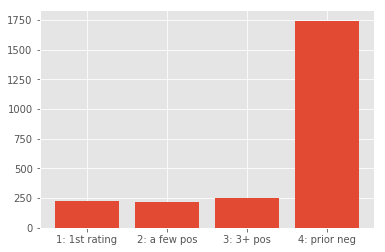

In [17]:
labels, counts = np.unique(df[df['class']>0]['class'], return_counts=True)
labels = ['1: 1st rating', '2: a few pos', '3: 3+ pos', '4: prior neg']
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.show()
# df[df['class']>0].hist('class', bins=9, align='center')
# plt.xticks(range(1,4))

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35592 entries, 0 to 35591
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   rater                   35592 non-null  int64  
 1   ratee                   35592 non-null  int64  
 2   rating                  35592 non-null  int64  
 3   date                    35592 non-null  object 
 4   class                   35592 non-null  int64  
 5   binomial_rating         35592 non-null  int64  
 6   color                   35592 non-null  object 
 7   penwidth                35592 non-null  int64  
 8   num_ratings_received    35592 non-null  float64
 9   num_neg_received        35592 non-null  float64
 10  num_pos_received        35592 non-null  float64
 11  neg_ratings_pct         35592 non-null  float64
 12  rating_received_sum     35592 non-null  float64
 13  rating_received_avg     35592 non-null  float64
 14  days_since_first_rated  35592 non-null

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd2ab068a10>]],
      dtype=object)

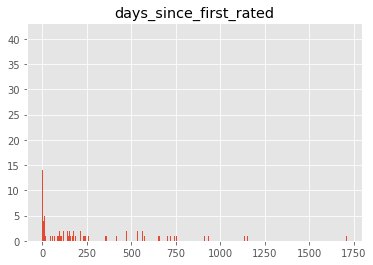

In [22]:
df[df['class']==3].hist('days_since_first_rated', bins=1000)

ATO is open for a long time, with a long time period since last review, and success negative reviews
so won't know of first negative review (expept that it's been awhile and maybe that's enough)
on second review will be looking at prior neg and long time since open and short time since last review (how will you know about the long gap prior to ATO?)

In [60]:
df[df['class']==3].groupby('rating')['rating'].count()

# rating of -10 indicates 'fraud'
# rating between -1 and -9 inclusive indicates 'untrustworthy'

# to do: make a separate bar chart of everybody's negative rating and explain the two categories or rating_type
# can make a third category for now of 'trustworthy' - then can blow 4 apart into these two buckets - who
# does transaction with prior -10 anyway????? data doesn't make sense?

rating
-10    245
-9       3
-8       5
-7       3
-5      38
-4       5
-3      26
-2      17
-1     183
Name: rating, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8b05334c50>]],
      dtype=object)

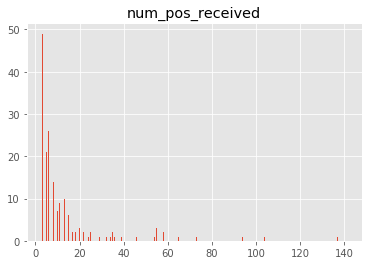

In [66]:
# After a certain threshold they could be ATO if followed by more negative ratings

# *****  probably good to check days active to determine if ATO ********

df[(df['class']==3) & (df['rating']==-10)].hist('num_pos_received', bins=500)

In [ ]:
For this project I will compare three different methods for detecting ratings manipulation.
    1. Use of features based on Account profile
    2. Use of velocity features
    3. Use of graph theory features

determine velocity time frame: 
measure frequency of multiple ratings activity within different time intervals.

2 records is reasonable because users will rate each other in close proximity to the conclusion of a transaction. 
- historgram of users and max velocity score
- cdf to show % accounts using  or not using automation???
- determining velocity time frame - x axis is number of transactions in time frame
    - - y axis is number of accounts in velocity range
    - - draw a curve for different velocity time intervals
    
for min in range(1,10):
    max(count number of prior transactions for each user)
    get a user count for each number above
    

### Account Profile Features
days since first activity
days since last activity

num positive ratings
num negative ratings
average rating
negative rating percent

need to do EDA on prior sequential ratings
